# Confidence Intervals

This notebook overviews three types of intervals that scalecast offers across several model classes and three different datasets. The efficacy of each interval is scored with [Mean Scaled Interval Score (MSIS)](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis). Requires `scalecast>=0.16.4`.  

**Definition of terms:**  

* **Bootstrapped Intervals (default):**  
  - This is a computationally cheap method that works by drawing randomly from in-sample residuals and measuring distance from actual values.  
  - It is not dynamic (interval ranges are constant throughout a given horizon).  
  - Models that are overfit usually get an extremely tight (and inaccurate) confidence interval.  
  - All scalecast models get this interval by default for any model run with `auto_forecast()` or `manual_forecast()`.  
* **Naive Intervals:**
  - This method determines a range of possible values within a given certainty for out-of-sample point predictions by measuring how far different model classes' precitions are from one another in each step of a given horizon.  
  - It can create a dynamic interval that expands as predictions move further out.  
  - If you call a diverse set of models on the same series, this method could give a robust interval.  
  - If models are very close to each other but very far from an actual value, it will give an interval that is too tight.  
  - If one model is an outlier in how close or far it is from actual values, it can skew all confidence intervals.  
  - In scalecast, it is computationally cheap and has to be called explicitly in order for models to receive it.   
* **Backtested Intervals:**
  - This method determines confidence intervals by backtesting a given model on out-of-sample forecast horizons.
  - The ranges of the resulting confidence intervals are determined by the standard deviation of each step in each backtest iteration.  
* **Probabilistic Intervals:**
  - This method construcsts intervals using conformal prediction from the [mapie](https://github.com/scikit-learn-contrib/MAPIE) package. In scalecast, call `proba_forecast()` or `auto_forecast(probabilistic=True)` to produce them.
  - Conformal prediction is considered state-of-the-art for constructing time-series confidence intervals.
  - It is a technique that considers the trained model itself and its strengths/limitations in predicting unseen data.
  - It does come with its downsides as implemented in scalecast -- it can't evaluate over small test sets and it is only currently available for scikit-learn model classes.
  
Each one of these intervals were better than and worse than the others at times (according to MSIS) depending on the series being forecast and the model. For data that is differenced, the bootstrapped and proabilistic intervals are undifferenced, causing them to be inflated wider than they perhaps should be. It is not clear if there is a better way to apply these intervals on differenced data--until a better way is found, this is what the package will do.

To evaluate the intervals, we leave out a section of each series to score out-of-sample. This is usually not necessary for scalecast, as all models are tested automatically, but the confidence intervals can overfit on any test set stored in the `Forecaster` object due to leakage that occurs when constructing these intervals. Scalecast intervals are compared to ARIMA intervals on the same series in the last section of this notebook. The series used in this example are ordered from easiest-to-hardest to forecast. Different results could be obtained if certain parameters are changed, such as the model classes used and the number of backtest iterations for that interval type.  

**Sections:**  
[Daily Website Visitors](#Daily-Website-Visitors)  
[Housing Starts](#Housing-Starts)  
[Avocado Sales](#Avocado-Sales)  
[All Aggregated Results](#All-Aggregated-Results)  
[Benchmark Against StatsModels ARIMA](#Benchmark-Against-StatsModels-ARIMA)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics
from scalecast.notebook import tune_test_forecast
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

In [2]:
models = (
    'mlr',
    'elasticnet',
    'ridge',
    'knn',
    'xgboost',
    'lightgbm',
    'gbt',
) # these are all scikit-learn models or APIs
# this will be used later to fill in results
results_template = pd.DataFrame(index=models)

In [3]:
def score_cis(results, fcsts, ci_name, actuals, obs, val_len, models=models, m_=1):
    for m in models:
        results.loc[m,ci_name] = metrics.msis(
            a = actuals,
            uf = fcsts[m+'_upperci'],
            lf = fcsts[m+'_lowerci'],
            obs = obs,
            m = m_,
        )
    return results

In [4]:
GridGenerator.get_example_grids()

## Daily Website Visitors

- Link to data: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
- We will use a length of 180 observations (about half a year) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 60-day forecast horizon  

In [5]:
val_len = 180
fcst_len = 60

In [6]:
data = pd.read_csv('daily-website-visitors.csv',parse_dates=['Date']).set_index('Date')
data.head()

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582",1430,152
2014-09-15,2,Monday,2,"3,621","2,528",2297,231
2014-09-16,3,Tuesday,3,"3,698","2,630",2352,278
2014-09-17,4,Wednesday,4,"3,667","2,614",2327,287
2014-09-18,5,Thursday,5,"3,316","2,366",2130,236


In [7]:
visits_sep = data['First.Time.Visits'].iloc[-fcst_len:]
visits = data['First.Time.Visits'].iloc[:-fcst_len]

In [8]:
f=Forecaster(
    y=visits,
    current_dates=visits.index,
    future_dates=fcst_len
)
f.set_test_length(0)
f.set_validation_length(val_len)
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-06-20T00:00:00.000000000
    Freq=D
    N_actuals=2107
    ForecastLength=60
    Xvars=['t', 'dayofyearsin', 'dayofyearcos', 'daysin', 'daycos', 'dayofweeksin', 'dayofweekcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57']
    Differenced=0
    TestLength=0
    ValidationLength=180
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [9]:
tune_test_forecast(
    f,
    models,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
ms = f.export('model_summaries',determine_best_by='ValidationMetricValue')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','ValidationMetric','ValidationMetricValue','InSampleRMSE']]

,ModelNickname,ValidationMetric,ValidationMetricValue,InSampleRMSE
0,ridge,rmse,220.618829,188.747084
1,lightgbm,rmse,221.138098,109.903207
2,elasticnet,rmse,221.545927,188.151129
3,mlr,rmse,221.986965,187.970567
4,gbt,rmse,238.107802,143.326868
5,xgboost,rmse,238.969842,16.562717
6,knn,rmse,394.391733,175.978259


We will demonstrate how the confidence intervals change as they are re-evaluated using the best model according to the test MAE: xgboost.

### Bootstrapped Interval (default)

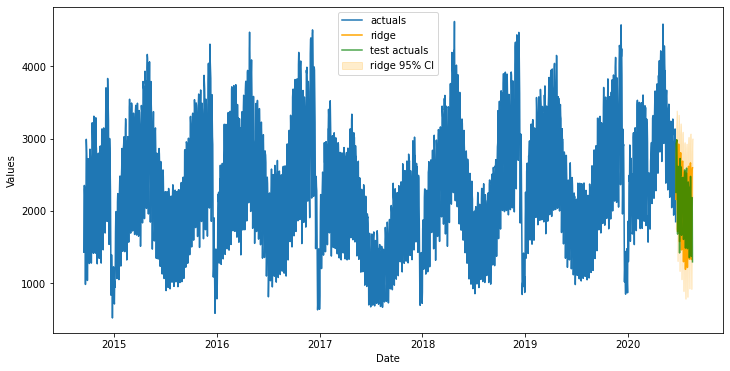

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax)
sns.lineplot(
    y = 'First.Time.Visits',
    x = 'Date',
    data = visits_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

XGBoost overfit on this dataset, so its default confidence interval is barely noticeable. That is one of the downsides of the bootstrapped method from in-sample residuals.

In [12]:
# export test-set preds and confidence intervals
fcsts1 = f.export("lvl_fcsts",cis=True)
fcsts1.head()

,DATE,gbt,gbt_upperci,gbt_lowerci,lightgbm,lightgbm_upperci,lightgbm_lowerci,xgboost,xgboost_upperci,xgboost_lowerci,...,knn_lowerci,ridge,ridge_upperci,ridge_lowerci,elasticnet,elasticnet_upperci,elasticnet_lowerci,mlr,mlr_upperci,mlr_lowerci
0,2020-06-21,2159.120209,2466.426357,1851.814061,2187.509702,2420.717603,1954.301801,2064.940430,2094.806491,2035.074369,...,1783.21086,2160.142239,2566.028515,1754.255962,2169.875639,2477.691545,1862.059733,2176.226208,2552.419087,1800.033328
1,2020-06-22,2754.509656,3061.815804,2447.203508,2790.424464,3023.632365,2557.216563,2712.903809,2742.769870,2683.037748,...,2465.21086,2779.926022,3185.812299,2374.039746,2783.904819,3091.720725,2476.088914,2791.384043,3167.576922,2415.191163
2,2020-06-23,2784.054729,3091.360877,2476.748581,2885.596205,3118.804106,2652.388304,2833.567871,2863.433932,2803.701810,...,2553.71086,2904.323822,3310.210099,2498.437546,2905.372867,3213.188773,2597.556962,2915.018770,3291.211650,2538.825891
3,2020-06-24,2780.608856,3087.915004,2473.302709,2887.548310,3120.756211,2654.340409,2811.904053,2841.770114,2782.037992,...,2500.21086,2980.657307,3386.543584,2574.771030,2981.031827,3288.847733,2673.215921,2991.712971,3367.905850,2615.520091
4,2020-06-25,2898.010721,3205.316868,2590.704573,2880.996123,3114.204023,2647.788222,2831.970947,2861.837008,2802.104886,...,2580.21086,2929.909471,3335.795747,2524.023194,2933.083548,3240.899453,2625.267642,2938.756085,3314.948964,2562.563205


The values in the below table are [mean scaled interval scores](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis) for confidence intervals. Lower scores are better.

In [13]:
results = score_cis(
    results_template.copy(),
    fcsts1,
    'Bootstrapped (Default)',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default)
mlr,3.459389
elasticnet,3.869866
ridge,3.300422
knn,6.051902
xgboost,15.598470
lightgbm,4.746234
gbt,4.370513


### Naive Interval

- `Forecaster.reeval_cis()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reeval_cis)  

In [14]:
%%time
f.reeval_cis()

Wall time: 552 ms


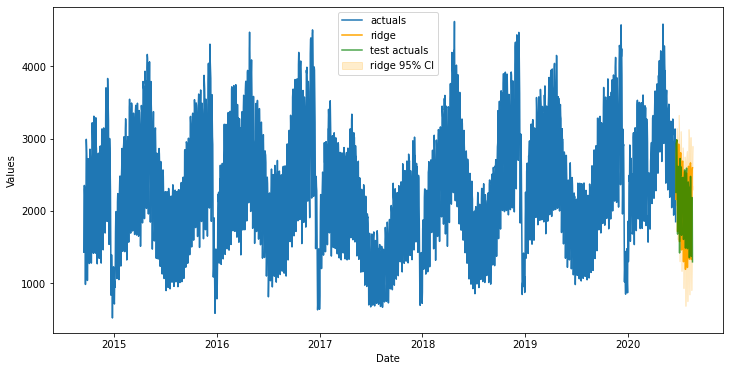

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax)
sns.lineplot(
    y = 'First.Time.Visits',
    x = 'Date',
    data = visits_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

The confidence interval is noticeable now and is dynamic -- for some observations it is further out from the point estimate than others. It has been constructed based on the dispersion of the point estimates from the other evaluated models.

In [16]:
fcsts2 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts2,
    'Naive',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive
mlr,3.459389,5.193808
elasticnet,3.869866,5.053044
ridge,3.300422,5.085858
knn,6.051902,5.860702
xgboost,15.598470,4.148681
lightgbm,4.746234,4.677486
gbt,4.370513,5.164851


### Backtested Interval

In [17]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 1min 34s


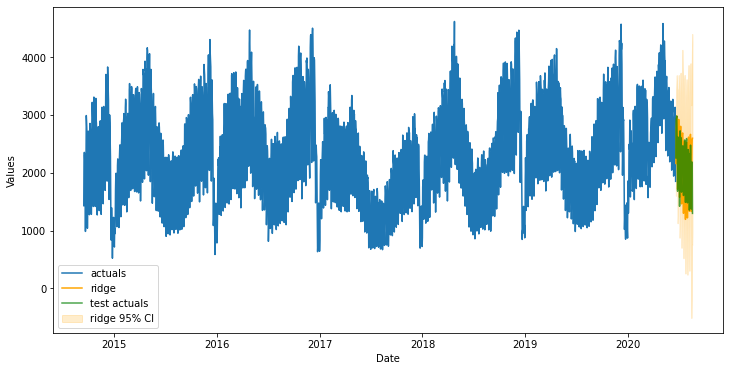

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax)
sns.lineplot(
    y = 'First.Time.Visits',
    x = 'Date',
    data = visits_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

This is also a dynamic confidence interval, but is obtained solely from XGBoost's own point estimates over 10 test sets in the data. The first point's interval is based on the standard deviation of the residual for all 10 tests of the first step, same for the second point and beyond.  

In [19]:
fcsts3 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts3,
    'Backtest',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive,Backtest
mlr,3.459389,5.193808,4.353309
elasticnet,3.869866,5.053044,4.348494
ridge,3.300422,5.085858,4.351216
knn,6.051902,5.860702,3.790439
xgboost,15.598470,4.148681,4.151873
lightgbm,4.746234,4.677486,4.036414
gbt,4.370513,5.164851,3.988124


### Probabilistic Interval
- `Forecaster.proba_forecast()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.proba_forecast).

In [20]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

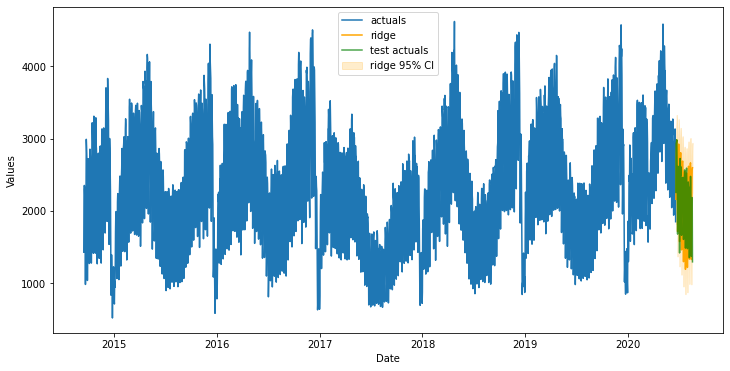

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax)
sns.lineplot(
    y = 'First.Time.Visits',
    x = 'Date',
    data = visits_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [22]:
fcsts4 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts4,
    'Probabilistic',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,3.459389,5.193808,4.353309,3.559296
elasticnet,3.869866,5.053044,4.348494,3.331146
ridge,3.300422,5.085858,4.351216,3.554842
knn,6.051902,5.860702,3.790439,3.515103
xgboost,15.598470,4.148681,4.151873,3.448501
lightgbm,4.746234,4.677486,4.036414,3.497492
gbt,4.370513,5.164851,3.988124,3.584811


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For website visitors, it was the backtest method.  

In [23]:
ci_type_score = results.mean()
ci_type_score.sort_values()

Probabilistic             3.498741
Backtest                  4.145696
Naive                     5.026347
Bootstrapped (Default)    5.913828
dtype: float64

In [24]:
model_score = results.mean(axis=1)
model_score.sort_values()

ridge         4.073084
mlr           4.141451
elasticnet    4.150638
lightgbm      4.239407
gbt           4.277075
knn           4.804536
xgboost       6.836881
dtype: float64

## Housing Starts  

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA  
- We will use a length of 96 observations (8 years) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 24-month forecast horizon  

In [25]:
import pandas_datareader as pdr

In [26]:
val_len = 96
fcst_len = 24

In [27]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
housing.head()

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5


In [28]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [29]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
)

f.set_test_length(0)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2019-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=726
    ForecastLength=24
    Xvars=['lnt', 'monthsin', 'monthcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99']
    Differe

In [30]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
ms = f.export('model_summaries',determine_best_by='ValidationMetricValue')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','ValidationMetric','ValidationMetricValue','InSampleRMSE']]

,ModelNickname,ValidationMetric,ValidationMetricValue,InSampleRMSE
0,xgboost,rmse,7.528008,0.597922
1,lightgbm,rmse,7.689658,9.122382
2,gbt,rmse,7.695883,7.318865
3,elasticnet,rmse,7.915973,10.109005
4,knn,rmse,8.222449,11.426439
5,ridge,rmse,8.283957,9.574088
6,mlr,rmse,8.403749,9.460389


### Bootstrapped Interval (default)

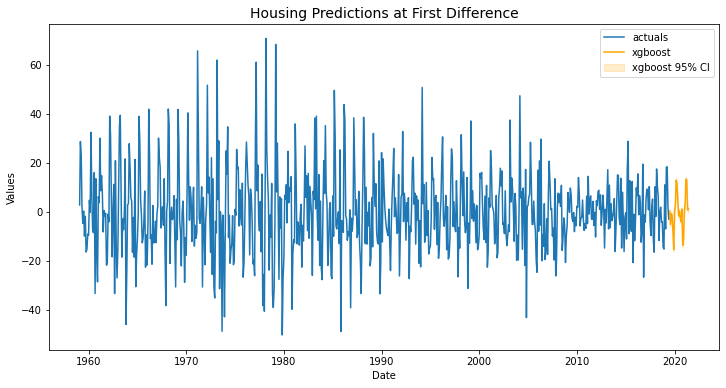

In [32]:
f.plot(ci=True,models=best_model)
plt.title('Housing Predictions at First Difference',size=14)
plt.show();

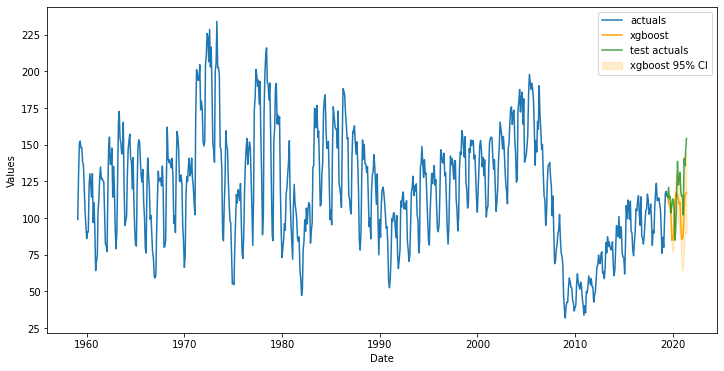

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [34]:
housing_fcsts1 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    results_template.copy(),
    housing_fcsts1,
    'Bootstrapped (Default)',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12, # monthly seasonality
)
housing_results

,Bootstrapped (Default)
mlr,26.565683
elasticnet,34.040801
ridge,24.204782
knn,30.612180
xgboost,14.546523
lightgbm,25.729532
gbt,19.648136


### Naive Interval

In [35]:
%%time
f.reeval_cis()

Wall time: 246 ms


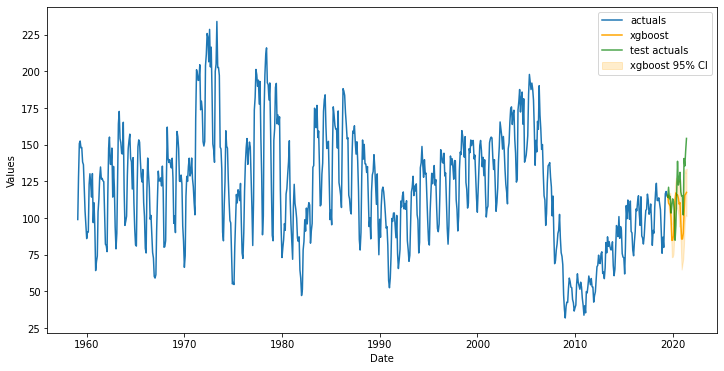

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [37]:
housing_fcsts2 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts2,
    'Naive',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive
mlr,26.565683,37.196578
elasticnet,34.040801,14.747269
ridge,24.204782,29.505055
knn,30.612180,15.461850
xgboost,14.546523,17.288780
lightgbm,25.729532,11.789265
gbt,19.648136,13.617536


### Backtested Interval

In [38]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 37.1 s


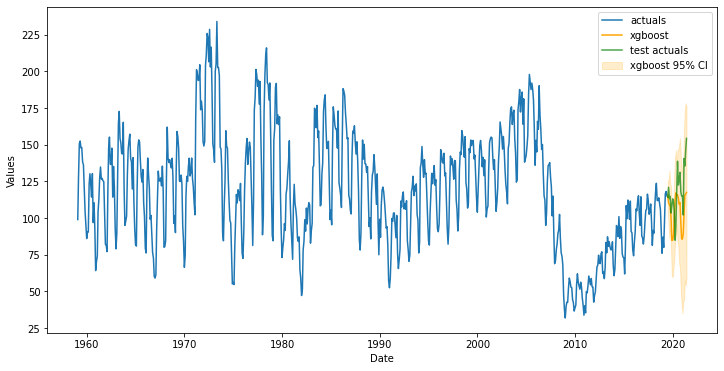

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [40]:
housing_fcsts3 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts3,
    'Backtest',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive,Backtest
mlr,26.565683,37.196578,8.105723
elasticnet,34.040801,14.747269,4.892812
ridge,24.204782,29.505055,6.681492
knn,30.612180,15.461850,4.731575
xgboost,14.546523,17.288780,4.109488
lightgbm,25.729532,11.789265,5.425319
gbt,19.648136,13.617536,4.833158


### Probabilistic Interval

In [41]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

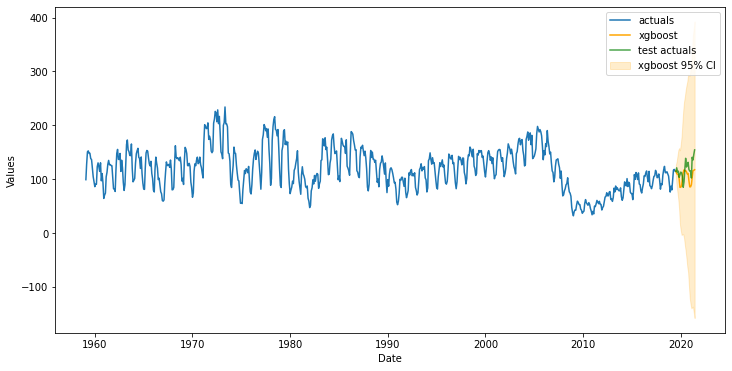

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [43]:
housing_fcsts4 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts4,
    'Probabilistic',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,26.565683,37.196578,8.105723,15.466862
elasticnet,34.040801,14.747269,4.892812,15.564714
ridge,24.204782,29.505055,6.681492,14.420801
knn,30.612180,15.461850,4.731575,17.435461
xgboost,14.546523,17.288780,4.109488,15.600398
lightgbm,25.729532,11.789265,5.425319,19.162037
gbt,19.648136,13.617536,4.833158,17.086754


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For housing starts, it was the backtest method.  

In [44]:
housing_ci_type_score = housing_results.mean()
housing_ci_type_score.sort_values()

Backtest                   5.539938
Probabilistic             16.391004
Naive                     19.943762
Bootstrapped (Default)    25.049662
dtype: float64

In [45]:
housing_model_score = housing_results.mean(axis=1)
housing_model_score.sort_values()

xgboost       12.886297
gbt           13.796396
lightgbm      15.526538
knn           17.060267
elasticnet    17.311399
ridge         18.703033
mlr           21.833711
dtype: float64

## Avocado Sales  

- Link to data: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  
- We will use a length of 13 observations (1 quarter) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 13-week forecast horizon  

In [46]:
# change display settings
pd.options.display.float_format = '{:,.2f}'.format

In [47]:
val_len = 20
fcst_len = 20

In [48]:
avocados = pd.read_csv('avocado.csv',parse_dates = ['Date'])
volume = avocados.groupby('Date')['Total Volume'].sum()

In [49]:
volume.reset_index().head()

,Date,Total Volume
0,2015-01-04,"84,674,337.20"
1,2015-01-11,"78,555,807.24"
2,2015-01-18,"78,388,784.08"
3,2015-01-25,"76,466,281.07"
4,2015-02-01,"119,453,235.25"


In [50]:
volume_sep = volume.iloc[-fcst_len:]
volume = volume.iloc[:-fcst_len]

In [51]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = fcst_len,
)

f.set_test_length(0)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=26,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2017-11-05T00:00:00.000000000
    Freq=W-SUN
    N_actuals=149
    ForecastLength=20
    Xvars=['t', 'weeksin', 'weekcos', 'monthsin', 'monthcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26']
    Differenced=1
    TestLength=0
    ValidationLength=20
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [52]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [53]:
ms = f.export('model_summaries',determine_best_by='ValidationMetricValue')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','ValidationMetric','ValidationMetricValue','InSampleRMSE']]

,ModelNickname,ValidationMetric,ValidationMetricValue,InSampleRMSE
0,gbt,rmse,"4,001,874.88","1,227,177.91"
1,elasticnet,rmse,"4,045,734.09","10,752,289.14"
2,knn,rmse,"4,428,582.27","11,976,981.06"
3,ridge,rmse,"4,632,927.80","10,088,903.55"
4,xgboost,rmse,"5,231,947.53",2.47
5,lightgbm,rmse,"5,532,156.77","10,149,703.19"
6,mlr,rmse,"6,468,766.92","8,716,538.56"


### Bootstrapped Interval (default)

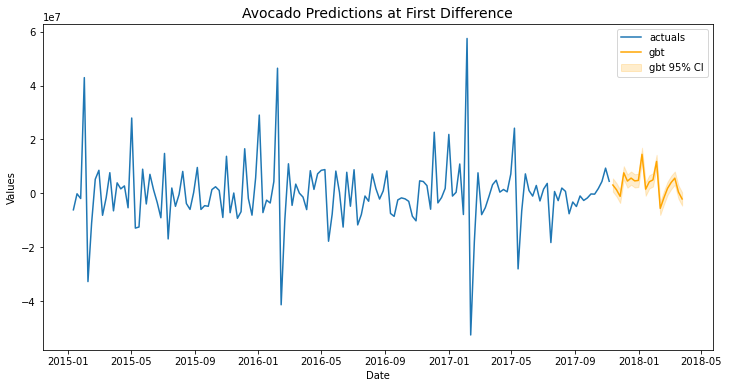

In [54]:
f.plot(ci=True,models=best_model)
plt.title('Avocado Predictions at First Difference',size=14)
plt.show();

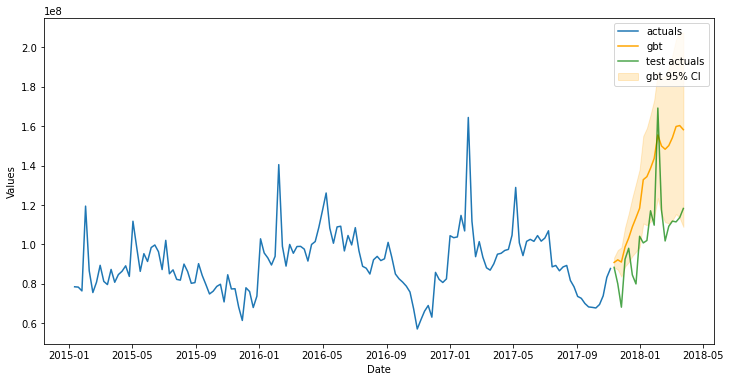

In [55]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'Total Volume',
    x = 'Date',
    data = volume_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [56]:
avc_fcsts1 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    results_template.copy(),
    avc_fcsts1,
    'Bootstrapped (Default)',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default)
mlr,43.65
elasticnet,43.77
ridge,56.63
knn,58.73
xgboost,49.93
lightgbm,51.68
gbt,28.46


### Naive Interval

In [57]:
%%time
f.reeval_cis()

Wall time: 160 ms


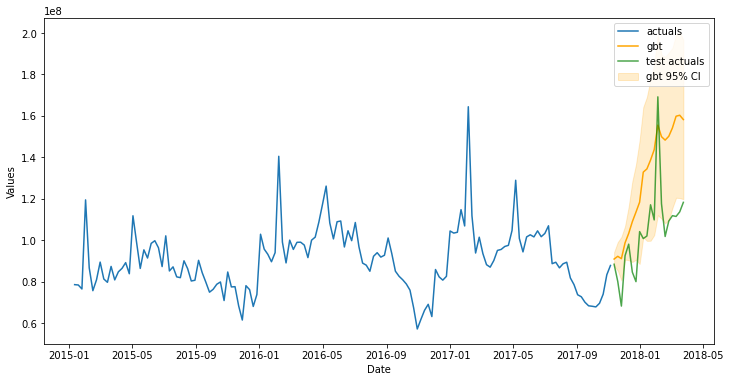

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'Total Volume',
    x = 'Date',
    data = volume_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [59]:
avc_fcsts2 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts2,
    'Naive',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive
mlr,43.65,21.60
elasticnet,43.77,14.89
ridge,56.63,15.35
knn,58.73,14.70
xgboost,49.93,18.23
lightgbm,51.68,12.06
gbt,28.46,23.09


### Backtested Interval

In [60]:
%%time
f.reeval_cis(method='backtest')

Wall time: 11.2 s


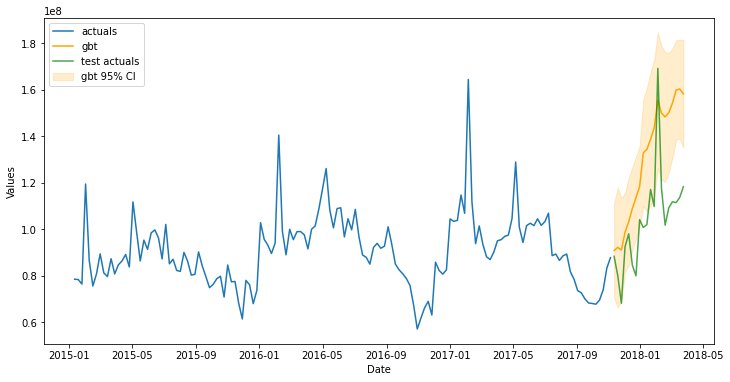

In [61]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'Total Volume',
    x = 'Date',
    data = volume_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [62]:
avc_fcsts3 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts3,
    'Backtest',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive,Backtest
mlr,43.65,21.60,54.15
elasticnet,43.77,14.89,15.65
ridge,56.63,15.35,17.31
knn,58.73,14.70,23.50
xgboost,49.93,18.23,15.77
lightgbm,51.68,12.06,12.03
gbt,28.46,23.09,48.80


### Probabilistic Interval

In [63]:
for m in tqdm(models):
    f.set_estimator(m)
    f.proba_forecast(
        **ms.loc[ms['ModelNickname'] == m, 'HyperParams'].values[0], # grab the already-optimized hyperparams
        dynamic_testing = fcst_len,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

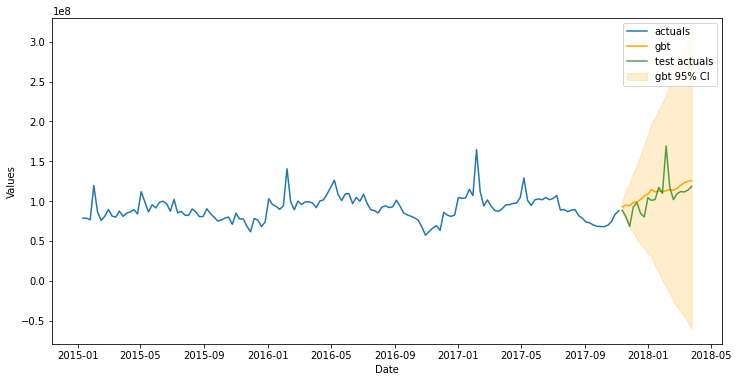

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models=best_model,ax=ax,level=True)
sns.lineplot(
    y = 'Total Volume',
    x = 'Date',
    data = volume_sep.reset_index(),
    ax = ax,
    label = 'test actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [65]:
avc_fcsts4 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts4,
    'Probabilistic',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive,Backtest,Probabilistic
mlr,43.65,21.60,54.15,44.37
elasticnet,43.77,14.89,15.65,25.46
ridge,56.63,15.35,17.31,28.92
knn,58.73,14.70,23.50,35.58
xgboost,49.93,18.23,15.77,37.10
lightgbm,51.68,12.06,12.03,41.12
gbt,28.46,23.09,48.80,24.86


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For avocados, it was the naive method.  

In [66]:
avc_ci_type_score = avc_results.mean()
avc_ci_type_score.sort_values()

Naive                    17.13
Backtest                 26.74
Probabilistic            33.92
Bootstrapped (Default)   47.55
dtype: float64

In [67]:
avc_model_score = avc_results.mean(axis=1)
avc_model_score.sort_values()

elasticnet   24.94
lightgbm     29.23
ridge        29.55
xgboost      30.26
gbt          31.30
knn          33.13
mlr          40.94
dtype: float64

## All Aggregated Results
- All MSIS scores for each model on each series are stored in the below dataframe.

In [68]:
all_results = {
    'visitors':results,
    'housing starts':housing_results,
    'avocados':avc_results
}

all_results_df = pd.DataFrame()
for k, df in all_results.items():
    df['forecast of'] = k
    all_results_df = pd.concat(
        [all_results_df,df]
    )
    
all_results_df

,Bootstrapped (Default),Naive,Backtest,Probabilistic,forecast of
mlr,3.46,5.19,4.35,3.56,visitors
elasticnet,3.87,5.05,4.35,3.33,visitors
ridge,3.30,5.09,4.35,3.55,visitors
knn,6.05,5.86,3.79,3.52,visitors
xgboost,15.60,4.15,4.15,3.45,visitors
lightgbm,4.75,4.68,4.04,3.50,visitors
gbt,4.37,5.16,3.99,3.58,visitors
mlr,26.57,37.20,8.11,15.47,housing starts
elasticnet,34.04,14.75,4.89,15.56,housing starts
ridge,24.20,29.51,6.68,14.42,housing starts


In [69]:
all_results_df.mean().sort_values()

Backtest                 12.14
Naive                    14.03
Probabilistic            17.94
Bootstrapped (Default)   26.17
dtype: float64

Generally speaking, the backtest interval was the best, followed by naive, followed by bootstrapped. All three of them were fairly close to one another.  

In [70]:
models_pivoted = pd.pivot_table(
    all_results_df.reset_index(),
    index = 'index',
    values = all_results_df.columns.to_list()[:-1],
    aggfunc = np.mean,
    sort = False,
)
models_pivoted

,Bootstrapped (Default),Naive,Backtest,Probabilistic
index,,,,
mlr,24.56,21.33,22.20,21.13
elasticnet,27.23,11.56,8.30,14.79
ridge,28.04,16.65,9.45,15.63
knn,31.80,12.01,10.67,18.84
xgboost,26.69,13.22,8.01,18.72
lightgbm,27.39,9.51,7.16,21.26
gbt,17.49,13.96,19.21,15.18


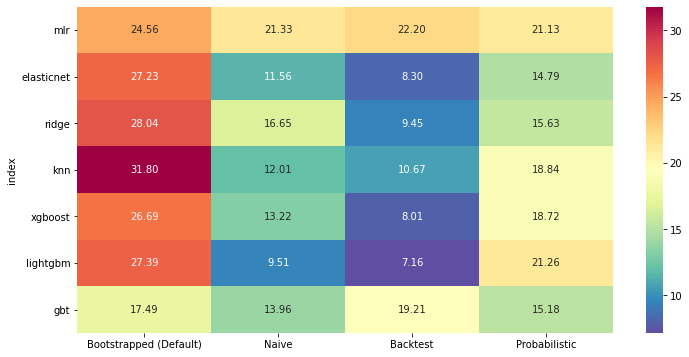

In [81]:
_, ax = plt.subplots(figsize=(12,6))
sns.heatmap(
    models_pivoted,
    annot=True,
    fmt='.2f',
    cmap="Spectral_r",
    ax=ax
)
plt.show()

Bootstrapped intervals seem to have a good or bad score, without a lot in the middle. Naive is more in the middle of the three methods and most of the backtest intervals score well.

## Benchmark Against StatsModels ARIMA
- Confidence intervals come from StatsModels but the auto-ARIMA process is from [PMDARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

In [72]:
from scalecast.auxmodels import auto_arima

In [73]:
all_series = {
    # series,out-of-sample series,seasonal step
    'visitors':[visits,visits_sep,1],
    'housing starts':[starts,starts_sep,12],
    'avocados':[volume,volume_sep,1]
}
arima_benchmark_results = pd.DataFrame()

In [75]:
for k, v in all_series.items():
    print(k)
    f = Forecaster(
        y=v[0],
        current_dates=v[0].index,
        future_dates=len(v[1]),
        test_length = 0,
    )
    auto_arima(f,m=v[2],train_only=False)
    cis = f.regr.get_forecast(len(v[1])).conf_int()
    arima_benchmark_results.loc[k,'MSIS'] = metrics.msis(
        a = v[1].values,
        uf = cis.T[1],
        lf = cis.T[0],
        obs = v[0].values,
        m = v[2],
    )

visitors
housing starts
avocados


In [76]:
arima_benchmark_results

,MSIS
visitors,5.79
housing starts,5.62
avocados,19.94


In [77]:
arima_benchmark_results.mean()

MSIS   10.45
dtype: float64

In [78]:
def highlight_rows(row):
    ret_row = ['']*5
    for i, c in enumerate(all_results_df.iloc[:,:-1]):
        if row[c] < row['ARIMA']:
            ret_row[i] = 'background-color: lightgreen;'
        else:
            ret_row[i] = 'background-color: lightcoral;'
    return ret_row

all_results_df_arima = all_results_df.merge(
    arima_benchmark_results.reset_index(),
    left_on='forecast of', 
    right_on = 'index', 
    how = 'left'
)

all_results_df_arima = all_results_df_arima.rename({'MSIS':'ARIMA'},axis=1)
all_results_df_arima = all_results_df_arima[all_results_df.columns.to_list()[:-1] + ['ARIMA']]
all_results_df_arima.index = all_results_df.reset_index()[['index','forecast of']].apply(lambda x: '-'.join(x),axis=1)

all_results_df_arima.style.apply(
    highlight_rows,
    axis=1,
)

,Bootstrapped (Default),Naive,Backtest,Probabilistic,ARIMA
mlr-visitors,3.459389,5.193808,4.353309,3.559296,5.790405
elasticnet-visitors,3.869866,5.053044,4.348494,3.331146,5.790405
ridge-visitors,3.300422,5.085858,4.351216,3.554842,5.790405
knn-visitors,6.051902,5.860702,3.790439,3.515103,5.790405
xgboost-visitors,15.598470,4.148681,4.151873,3.448501,5.790405
lightgbm-visitors,4.746234,4.677486,4.036414,3.497492,5.790405
gbt-visitors,4.370513,5.164851,3.988124,3.584811,5.790405
mlr-housing starts,26.565683,37.196578,8.105723,15.466862,5.624713
elasticnet-housing starts,34.040801,14.747269,4.892812,15.564714,5.624713
ridge-housing starts,24.204782,29.505055,6.681492,14.420801,5.624713


The above table shows which scalecast intervals performed better or worse than the ARIMA interval. On the dataset that didn't need to be differenced, the derived intervals almost always beat ARIMA, with the probablistic interval perforing the best. For the other two datasets, the naive and backtested intervals performed better because they are re-evaluated for level data under this framework. So, there are drawbacks to using probabilistic and bootstrapped intervals in these examples, but the probalistic interval should be used when the series doesn't have to be differenced. For other applications, users should use their best judgement when constructing intervals.